In [20]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns
from tabulate import tabulate


# Load the data

In [21]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [22]:
len(traindataset) // 32


419

In [23]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [24]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-05 08:26:49.908 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [25]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [26]:
# TODO ~ about 4 lines of code
# 8 regels code toegevoegd door Mirjam Bleumink, notebook 2 vraag 1
incorrect = [0, 0, 0, 0]
correct = [0, 0, 0, 0]
for x, y in traindataset:
    ynaive = np.random.randint(4)
    if d[y] == ynaive:
        correct[d[y]] += 1
    else:
        incorrect[d[y]] += 1
# Einde toevoeging Mirjam Bleumink


In [27]:
# Mirjam Bleumink antwoord op notebook 2, vraag 1
print("Naieve voorspelling % goed voorspeld, berekend per categorie")
for Class in d:
    accuracy = int(
        (correct[d[Class]] / (correct[d[Class]] + incorrect[d[Class]])) * 100
    )
    print(
        f"Class {Class} ({d[Class]}) heeft een accuracy van {accuracy}% ({correct[d[Class]]} van {(correct[d[Class]] + incorrect[d[Class]])})"
    )

print("--------------------")

print(
    "Naieve voorspelling % goed voorspeld, berekend ten opzichte van de totale dataset"
)
for Class in d:
    accuracy = int((correct[d[Class]] / len(traindataset)) * 100)
    print(
        f"Class {Class} ({d[Class]})  heeft een accuracy van {accuracy}% ({correct[d[Class]]} van {len(traindataset)})"
    )


Naieve voorspelling % goed voorspeld, berekend per categorie
Class humor (0) heeft een accuracy van 25% (1071 van 4213)
Class reuters (1) heeft een accuracy van 25% (1062 van 4186)
Class wiki (2) heeft een accuracy van 24% (1022 van 4181)
Class proverbs (3) heeft een accuracy van 24% (203 van 831)
--------------------
Naieve voorspelling % goed voorspeld, berekend ten opzichte van de totale dataset
Class humor (0)  heeft een accuracy van 7% (1071 van 13411)
Class reuters (1)  heeft een accuracy van 7% (1062 van 13411)
Class wiki (2)  heeft een accuracy van 7% (1022 van 13411)
Class proverbs (3)  heeft een accuracy van 1% (203 van 13411)



<font color=blue> Reflect on what you see.</font>                                    De categorie proverbs (3) heeft een lager percentage bij een naieve voorspelling, gerekend ten opzichte van de gehele populatie (2e overzicht). Bij een evenredig verdeelde populatie van de trainingsset zou je verwachten dat de naieve voorspelling voor alle categorieen gelijk is.
<font color=blue> What does this mean?</font>                                        De populatie in de traininsset is niet evenredig verdeeld. Nader onderzoek (zie overzicht hieronder) wijst uit dat de verdeling inderdaad niet evenredig is. "proverbs" beslaat slechts 6% van de trainingsset, terwijl de andere categorieen allemaal 31% voorkomen.
<font color=blue> What implications does this have?</font>                           Voor het trainen van "proverbs" is maar weinig trainingsdata beschikbaar. Dit kan resulteren in een model dat de weinige voorkomens van "proverbs" gaat onthouden en daarmee overfitten. Dit gaat ten koste van de generalisatie die benodigd is om goed te kunnen voorspellen.
<font color=blue> Why is that good/bad?</font>                                       Waarschijnlijk gaat het model minder goed presteren op de trainingsset voor de categorie "proverbs"
<font color=blue> Are there things down the line that could cause a problem?</font>  Een model dat overfit op een categorie, zal niet goed presteren. Ik zal maatregelen moeten nemen bij het trainen om overfitten te voorkomen.

In [28]:
for Class in d:
    population = int(correct[d[Class]]) + int(incorrect[d[Class]])
    population_perc = int((population / len(traindataset)) * 100)

    print(
        f"Class {Class} komt {population} keer voor in de traindataset. Dit is {population_perc}% van het totaal"
    )


Class humor komt 4213 keer voor in de traindataset. Dit is 31% van het totaal
Class reuters komt 4186 keer voor in de traindataset. Dit is 31% van het totaal
Class wiki komt 4181 keer voor in de traindataset. Dit is 31% van het totaal
Class proverbs komt 831 keer voor in de traindataset. Dit is 6% van het totaal


# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [29]:
# TODO ~ about 4 lines of code
# 5 regels code toegevoegd Mirjam Bleumink, notebook 2 vraag 1
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        label_int = d[label]
        return label_int
# Einde toevoeging Mirjam Bleumink


In [30]:
# Mirjam Bleumink aanvullende test als antwoord op notebook 2 vraag 2
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
for x, y in traindataset[:3]:
    x1, y1 = preprocessor([(x, y)])
    data = [
        ["Originele tekst (x)", x],
        ["Originele label (y)", y],
        ["x na preprocessing ", x1],
        ["y na preprocessing", y1],
    ]
    print(tabulate(data))
    print(" ")


-------------------  -----------------------------------------------------------------------------------------
Originele tekst (x)  What's the difference between a cow and 9/11? You can't milk a cow for a decade straight.
Originele label (y)  humor
x na preprocessing   tensor([[ 124,    2,  280,  140,    3, 1016,    7,  583,  798,   14,  146,  847,
                                 3, 1016,   10,    3, 2373, 2162]], dtype=torch.int32)
y na preprocessing   tensor([0])
-------------------  -----------------------------------------------------------------------------------------
 
-------------------  -------------------------------------------------------------------------------------
Originele tekst (x)  Two episodes were taped every other Tuesday , airing them on the subsequent Saturday.
Originele label (y)  wiki
x na preprocessing   tensor([[  23, 2901,   84, 5329,  138,   87, 1968, 9907,  120,   11,    2, 5330,
                              3266]], dtype=torch.int32)
y na preprocessin

To test the preprocessor:

In [31]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[  13,  295,   68, 6855,    4,   80,    3,  143]], dtype=torch.int32),
 tensor([3]))

# Set up the model
We can re-use the BaseDatastreamer

In [32]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset,
    batchsize=32,
    preprocessor=StylePreprocessor(max=20, vocab=v, clean=tokenizer.clean),
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset,
    batchsize=32,
    preprocessor=StylePreprocessor(max=20, vocab=v, clean=tokenizer.clean),
).stream()


In [33]:
x, y = next(trainstreamer)
print(x.shape, y.shape)
print(x[1])


torch.Size([32, 20]) torch.Size([32])
tensor([2376, 3206, 2693,  954,  307,  813,  334,    6,  241, 3168,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=torch.int32)


## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [34]:
from src.models import metrics
import torch

# TODO ~ 2 lines of code
# Mirjam Bleumink antwoord op notebook 2 vraag 3
# Aanvullende code voor deze vraag (tbv precision) opgenomen in metrics.py

metrics = [metrics.Accuracy(), metrics.F1Score(), metrics.Precision()]
loss_fn = torch.nn.CrossEntropyLoss()


#### <font color=green> Mirjam Bleumink Aanvullende code voor deze vraag (tbv precision) opgenomen in metrics.py </font>

## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [35]:
log_dir = settings.log_dir
log_dir = data_tools.dir_add_timestamp(log_dir)
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
# Mirjam Bleumink antwoord op notebook 2 vraag 4 - basis oplossing: NLP model met config dictionary

config = {
    "vocab": len(v),
    "input_size": 32,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

from src.models import rnn

model = rnn.NLPmodel(config)

print(model)


2022-07-05 08:26:50.983 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../models/20220705-0826


NLPmodel(
  (emb): Embedding(19308, 128)
  (rnn): GRU(128, 128, num_layers=3, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)


#### <font color=red>  Mirjam Bleumink antwoord op notebook 2, vraag 4 - bonus oplossing: zie de uitwerking in "02_style_detection_trax.ipynb" </font> 
Om te voorkomen dat de basis PyTorch oplossing en Trax oplossing elkaar in de weg zitten, zijn deze gescheiden. Alle uitwerkingen in Trax zijn in 02_style_detection_trax.ipynb opgenomen. Het tunen (laatste vraag van notebook 2) vindt ook in deze Trax notebook plaats. 

Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [36]:
# Mirjam Bleumink antwoord op notebook 2, vraag 4
print(f"The length of the dataset is: {len(traindataset)}")


The length of the dataset is: 13411


<font color=blue> Give the lenght of the traindataset, how many batches of 32 can you get out of it? </font> 13411/32 =  419,09 batches, dus 419 volledig gevulde batches en 1 batch die minder samples bevat.
<font color=blue> If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset? </font>  1 epoch beslaat een hele trainingdataset, daarbij maakt het aantal trainingsets niet uit. Als je echter een random set van samples pakt en dus niet bij elke epoch de volledige dataset doorloopt, zou je 419,09 trainingsteps nodig hebben (zie voorgaande vraag). 419,09/25 = 16,76. Je moet dus minimaal 17 keer een random set van 25 samples gebruiken (waarbij elke trainingstep dan 32 samples in de batch heeft zitten) om de hele trainingdataset van 13411 samples te doorlopen.
<font color=blue> What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once?</font> Zie de voorgaande vraag, minimaal 17 epochs
<font color=blue> A reasonable epoch lenght would be...</font> Een goede stelregel is om minimaal 3 keer de volledige training dataset te doorlopen in een training. Bij een instelling van batchsize 32 en trainsteps 25, heb je 17 epochs nodig om de dataset 1 keer te doorlopen. 3 x 17 = 51. Als het model na die 51 epochs alsnog leert, kan dit naar boven bijgesteld worden. Als het model eerder al klaar is met leren, kan dit naar beneden bijgesteld worden om het risico op overfitting te minimaliseren. Ik zou bij het tunen beginnen met 51 en dit in meerdere tuning-tests ophogen, waarbij je kunt stoppen wanneer uit een dalende accuracy blijkt dat hij niet meer leert. 

In [37]:
# Mirjam Bleumink antwoord op notebook 2 vraag 4 - trainen van basis oplossing: NLP model
from src.training import train_model

model = train_model.trainloop(
    epochs=51,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-07-05 08:26:51.171 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../models/20220705-0826/20220705-0826
100%|██████████| 25/25 [00:02<00:00, 12.16it/s]
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-DDG3aTJy-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-DDG3aTJy-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-DDG3aTJy-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classific

#### <font color=red> Mirjam Bleumink antwoord op notebook 2, vraag 4 - bonus oplossing: zie de uitwerking in "02_style_detection_trax.ipynb" </font>

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

#### <font color=green> Mirjam Bleumink antwoord op notebook 2, vraag 4 - trainingsanalyse van basis oplossing: NLP model </font>

De logbestanden van deze run zijn te vinden in de volgende folder: examen-22/examen-22/models/basic/BasisNLP

<img src="../figures/BasisNLP.png">

Aan de loos van vooral de Test is te zien dat er iets gaande is tussen epoch 30 en 35. Mogelijk is dit het moment waarop hij begint te memoriseren van de categorie 'proverbs' data en dus gaat overfitten. In de loss van Train is ook te zien dat hij vanaf dat moment redelijk horizontaal loopt in de loss.  

In alle 3 de metrics (accuracy, F1score en precision) zien we deze fluctuatie ook terug. 

Voor een eerste run, niet getuned, valt de uiteindelijke score boven de 80% (Accuracy 88% en F1 score en Precision van 82%) mij mee. 

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

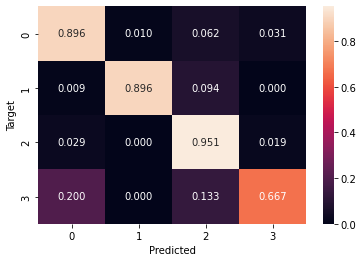

In [38]:
# Mirjam Bleumink antwoord op notebook 2 vraag 5 - evalueren van basis oplossing: NLP model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]


cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

### Mirjam Bleumink antwoord op notebook 2 vraag 5 - evalueren van basis oplossing: NLP model

<img src="../figures/basemodel_confusion_matrix.png">

<font color=blue> What is going on? </font> Uit deze matrix blijkt duidelijk dat het model de waarde 3 (proverbs) niet goed kan voorspellen. Slechts in iets meer dan de helft (55%) van de gevallen was de voorspelde uitkomst 3 (proverbs) correct. <font color=blue> How is your answer to Q1 relevant here? </font> Dit was te verwachten aangezien er maar een kleine trainingsset voor deze uitkomst beschikbaar is (zie eerdere analyse in vraag 1 van deze notebook). Het model lijkt de zinnen die een echte uitkomst 3 (proverbs) hebben, vaak als waarde 2 (wiki) te voorspellen (30%). 
De accuratesse van de overige voorspellingen zijn al heel goed, allen boven de 90%. De accuratesse van het volledige model wordt echter naar beneden gehaald door de lage accuratesse van de waarde 3 (proverbs). <font color=blue> What is a good metric here? </font> In het geval van niet gebalanceerde datasets, wat hier het geval is, is het beter om een F-metric te gebruiken in plaats van accuracy, zoals F1. F1 maakt onder andere gebruik van de Precision, welke ik ook in de metrcs heb opgenomen.  <font color=blue> Is there something you could do to fix/improve things, after you see these results? </font> Enkele stappen die ik kan nemen om overfitting ten gevolge van een kleine dataset te voorkomen of minimaliseren zijn: 
* Vroeg stoppen; als het model te lang traint, zat het in plaats van doorleren en verbeteren de waarden van de kleine dataset onthouden en daardoor overfitten
* Reguralisatie door het toevoegen van een dropout; door het toevoegen van een dropout zal het model minder leren van alle nodes in zijn geheel en daardoor minder overfitten   
* Gebruik een simpel model; hoe "uigebreider" het model is, hoe meer mogelijkheden het model heeft (in de diverse lagen) om de voorbeelden uit de trainingset te memoriseren en te verwerken in de gewichten
* Toevoegen van synthetische voorbeelden (SMOTE); door de dataset aan te vullen met synthetische voorbeelden van de uitkomst die minder voorkomt (in dit geval 3; proverbs) is de dataset evenredig verdeeld   


### <font color=red>  Mirjam Bleumink antwoord op notebook 2, vraag 5 - bonus oplossing: zie de uitwerking in "02_style_detection_trax.ipynb" </font>

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

#### <font color=red>  Mirjam Bleumink Het tunen van het model vindt plaats in "02_style_detection_trax.ipynb" </font>